Options Pricing Boundaries Machine Learning Method (EOP as a Lower boundary) - AOP = Multiplicator*EOP

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
import catboost
import optuna

In [3]:
# Reading files from the github repo model with bounds features
columns = ['asset_price', 'maturity', 'rate', 'div', 'ivol', 'european_op', 'american_op', 'lower_bound', 'upper_bound', 'normalized_american_op']

df = pd.read_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataIn/V3.csv')
df.columns = columns

df['multiplicator'] = df['american_op'] / df['european_op']
df = df.drop(['upper_bound'], axis=1)
df = df.drop(['lower_bound'], axis=1)

df = df.drop(['normalized_american_op'], axis=1)
df = df.drop(['american_op'], axis=1)

df.head()

,asset_price,maturity,rate,div,ivol,european_op,multiplicator
0,113.935171,0.285741,0.008467,0.023575,0.538127,6.612110,1.000000
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,1.009919
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,1.005138
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,1.014270
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,1.005179


In [9]:
#drop rows with infinite values in the multiplicator column 
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


In [33]:
# df multiplicator 95% quantile
df['multiplicator'].quantile(0.1)

1.0000000018130755

In [35]:
df = df[(df['multiplicator'] < df['multiplicator'].quantile(0.99)) & (df['multiplicator'] > 1)]

In [36]:
df['multiplicator'].describe()

count    89872.000000
mean         1.028360
std          0.058305
min          1.000000
25%          1.000188
50%          1.006343
75%          1.027510
max          1.500966
Name: multiplicator, dtype: float64

In [37]:
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (85378, 7)
Unseen Data For Predictions (4494, 7)


In [38]:
# Boundaries model 1 with ordinary features data preparation
from pycaret.regression import *
exp_model_dm_rt = setup(data = data, target = 'multiplicator', session_id=111, train_size = 0.95, 
                        normalize = True)

,Description,Value
0,session_id,111
1,Target,multiplicator
2,Original Data,"(85378, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(81109, 6)"


In [39]:
# Creating a model with ordinary features
top3 = compare_models(n_select = 3, exclude=['et','rf'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0027,0.0000,0.0062,0.9884,0.0028,0.0025,2.1560
lightgbm,Light Gradient Boosting Machine,0.0043,0.0001,0.0105,0.9672,0.0047,0.0039,0.9240
xgboost,Extreme Gradient Boosting,0.0047,0.0001,0.0108,0.9654,0.0049,0.0043,2.7370
knn,K Neighbors Regressor,0.0043,0.0002,0.0135,0.9461,0.0060,0.0038,0.0750
dt,Decision Tree Regressor,0.0066,0.0004,0.0204,0.8761,0.0092,0.0058,0.1630
gbr,Gradient Boosting Regressor,0.0098,0.0005,0.0215,0.8628,0.0098,0.0090,3.2520
lar,Least Angle Regression,0.0244,0.0016,0.0404,0.5142,0.0188,0.0227,0.0210
br,Bayesian Ridge,0.0244,0.0016,0.0404,0.5142,0.0188,0.0227,0.0340
ridge,Ridge Regression,0.0244,0.0016,0.0404,0.5142,0.0188,0.0227,0.0190
lr,Linear Regression,0.0244,0.0016,0.0404,0.5142,0.0188,0.0227,0.7310


In [40]:
tuned_top3 = [tune_model(i) for i in top3]
blender = blend_models(tuned_top3)
stacker = stack_models(tuned_top3)
best_mae_model = automl(optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0030,0.0001,0.0079,0.9822,0.0035,0.0027
1,0.0032,0.0001,0.0094,0.9750,0.0042,0.0029
2,0.0031,0.0001,0.0087,0.9792,0.0039,0.0028
3,0.0030,0.0001,0.0079,0.9820,0.0036,0.0027
4,0.0029,0.0001,0.0078,0.9791,0.0036,0.0027
5,0.0030,0.0001,0.0084,0.9796,0.0038,0.0028
6,0.0030,0.0001,0.0081,0.9803,0.0036,0.0027
7,0.0030,0.0001,0.0078,0.9815,0.0035,0.0027
8,0.0029,0.0000,0.0069,0.9853,0.0032,0.0026


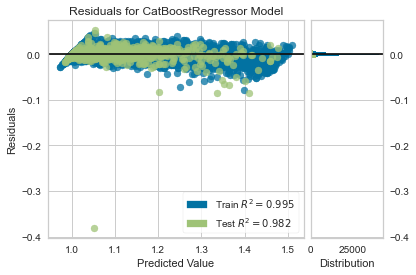

In [41]:
plot_model(best_mae_model)

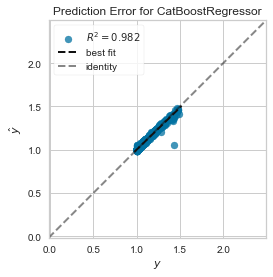

In [42]:
plot_model(best_mae_model, plot = 'error')

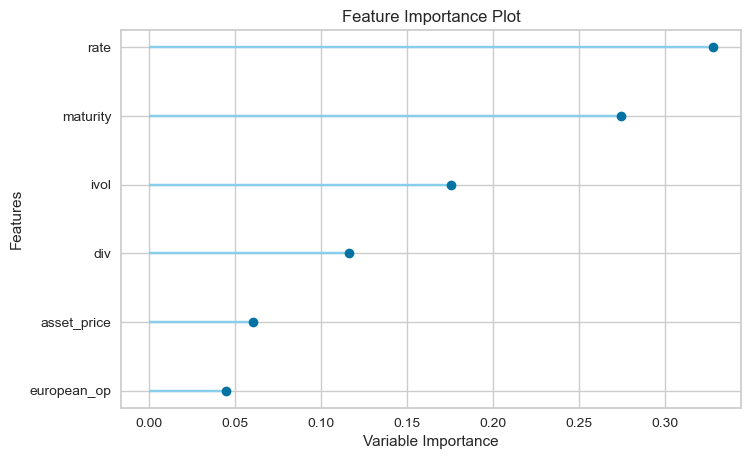

In [43]:
plot_model(tuned_top3[2], plot='feature')

In [44]:
print(best_mae_model)

In [46]:
save_model(best_mae_model, 'best_mae_model_indirect_eop_as_lower_bound_method')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='multiplicator',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='multiplicator')),
                 ('fix_perfect', Remove_100(target='multiplicator')),
                 ('clean_names', Clean_Colum_Names()),
      

In [45]:
final_best_model = finalize_model(best_mae_model)
print(final_best_model)

In [47]:
predict_model(final_best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0022,0.0000,0.0040,0.9957,0.0019,0.0021


,asset_price,maturity,rate,div,ivol,european_op,multiplicator,Label
0,0.534779,-0.027091,-0.903875,0.908615,-0.896269,-0.724633,1.000010,1.001494
1,0.172136,-0.698378,-0.507022,-0.605291,-0.132685,-0.828399,1.002570,1.003852
2,0.456056,0.802074,2.246687,-1.142194,0.601086,-0.145749,1.158639,1.160367
3,-0.298833,-0.810463,-1.272366,2.275515,1.569713,-0.067568,1.000006,1.000570
4,0.403288,-0.364473,-1.023047,0.091019,-1.223800,-1.098316,1.000008,1.000515
...,...,...,...,...,...,...,...,...
4264,-1.172145,-0.537686,0.293595,0.100795,-0.986272,0.488307,1.026979,1.028564
4265,1.025984,2.357501,-0.502361,-0.591349,-0.623562,-0.252183,1.030437,1.027150
4266,-0.870840,-0.442136,0.259466,1.398011,0.990540,0.852397,1.002690,1.003014
4267,0.407022,0.258924,-0.121264,-1.361703,1.164128,0.512473,1.024763,1.024017


In [48]:
unseen_predictions = predict_model(final_best_model, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0027,0.0000,0.0061,0.9901,0.0028,0.0025


,asset_price,maturity,rate,div,ivol,european_op,multiplicator,Label
0,105.079869,0.371638,0.020712,0.061659,0.125093,1.643791,1.000011,1.002543
1,75.305178,0.252698,0.010425,0.031964,0.515039,26.513517,1.000001,0.999311
2,112.713754,4.170755,0.092716,0.074318,0.252492,9.018933,1.185506,1.191137
3,102.526573,0.490773,0.021229,0.031768,0.546537,14.206036,1.000510,1.000161
4,112.569830,0.964490,0.097998,0.025377,0.471373,10.417145,1.055684,1.054574


In [61]:
all_predictions = predict_model(final_best_model, data=df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0023,0.0000,0.0041,0.9949,0.0019,0.0021


In [62]:
all_predictions['american_op'] = all_predictions['multiplicator'] * all_predictions['european_op']
all_predictions['predicted_american_op'] = all_predictions['Label'] * all_predictions['european_op']


In [63]:
all_predictions.head()

,asset_price,maturity,rate,div,ivol,european_op,multiplicator,Label,american_op,predicted_american_op
1,98.305405,0.813916,0.019547,0.018027,0.048863,2.601042,1.009919,1.029348,2.626842,2.677377
2,109.189731,0.713558,0.022951,0.015280,0.303538,6.397872,1.005138,1.004899,6.430745,6.429212
3,83.402084,2.879962,0.042272,0.058719,0.163288,20.609465,1.014270,1.018297,20.903553,20.986550
4,127.549831,0.907992,0.026664,0.017533,0.562713,12.093558,1.005179,1.003985,12.156191,12.141752
5,85.411375,0.467677,0.003564,0.097180,0.102791,18.220903,1.000000,1.000596,18.220904,18.231759


In [69]:
# MSE between columns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("MSE =", mean_squared_error(all_predictions['american_op'], all_predictions['predicted_american_op']))
print("MAE =", mean_absolute_error(all_predictions['american_op'], all_predictions['predicted_american_op']))

MSE = 0.0038786271686949043
MAE = 0.033839195391969924


In [70]:
#all predictions to csv
all_predictions.to_csv('/Users/nazymazimbayev/Documents/git-projects/dataoptions/DataOut/all_predictions(indirect_method_EOP_as_lower_bound).csv')